# Lending Club Loan Analysis

To Dos: ML on number of loans pulled form each grade
Show individual security by grade - talk about its limitations
Talk about pooling method & show CI graph = CLT -> approaches normality & easier for us to conduct tests
End with market volume graph on entire dataset

Answer questions using both approaches

Present the simplest method - take the best sharpe ratio class for 2009-2011 and use that for 2012
Present couple other approaches


Rational for taking out the bad classes - we may be trading on noises rather than confident signals
We may be violating the assumptions of t-test, so we can try a non-parametric test
import scipy.optimize as optimize


import scipy.optimize as optimize


def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b, c = params # <-- for readability you may wish to assign names to the component variables
    return a**2 + b**2 + c**2

initial_guess = [1, 1, 1]
result = optimize.minimize(f, initial_guess, bounds = [(.25, 1), (-1, 20),(0,1)])
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

May want to check average sizes of loans and change proportions accordingly

https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

## Summary

We approach this analysis from a perspective of an accredited or institutional investors, whose interests are maximizing risk-adjusted returns. Exploratory data analysis reveals that the market is growing at a healthy clip which is a positive factor for these investors who have liquidity needs. We also see that at an individual security level, these loans are highly volatile- making it a bad risk-adjusted investment without proper diversification. 

With that in mind, we take the approach of collecting a pool of investments, effectively creating a CDO of p2p lending securities. By Central Limit Theorem, these pool of investments approach normality and accompany other mathematically satisfying results. We will then take 80% of the data to derive insights onto how to construct a portfolio that can outperform a randomly selected pool of investments. We can measure the success by conducting either pooled t-test or looking at distribution of the randomly collected returns

Result show that by [ ] we can outperform a random selection


Because of the nature of this analysis, we are only able to use loans that have matured already to either defaulting or fully paid. An interesting follow up can be to looking a shorter term- buy hold then sell strategy by leveraging the note trading platform. This will allow us to model the loans with an assumption that they will be sold after, for example, 6 months of holding. This way, we can use data upto 6 months old to train our models

## Data Cleaning & Environment Set Up

##### Packages & Data Loading

In [188]:
###Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from IPython.core.display import HTML
import datetime
import math
import scipy.optimize as optimize
import statistics
plt.style.use('ggplot')

In [53]:
### data loading 
df = pd.read_csv('./data/loan.csv', low_memory=False)

##### Data Processing & Manipulation

In [54]:
###changing data type to appropriate date type 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)

In [55]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatmet
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [56]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month
df['mo_diff'] = pd.to_numeric((df['last_pymnt_yr'] - 
                          df['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])

In [169]:
###Flag for completed loans
searchfor = ['Fully Paid', 'Charged Off', 'Default']
defaults = ['Charged Off', 'Default']
df['loan_completion_flag']=  np.where(df['loan_status'].str.contains('|'.join(searchfor)) ,1, np.nan)
###Flag for fully paid loans
df['fully_paid'] = np.where(df['loan_status'].str.contains('Fully Paid') ,1, 
                                  np.where(df['loan_status'].str.contains('|'.join(defaults)) ,0,np.nan))


In [171]:
###Example output of above manipulation
df.head()[['loan_status','loan_completion_flag','fully_paid']]

,loan_status,loan_completion_flag,fully_paid
0,Fully Paid,1.0,1.0
1,Charged Off,1.0,0.0
2,Fully Paid,1.0,1.0
3,Fully Paid,1.0,1.0
4,Current,NaN,NaN


## Exploratory Data Analysis

##### Calculations & Assumptions

We calculate the return of a loan by looking at the IRR of its cash flows. We make an assumption that a total payment(inlcuding late fees and installments) are spread evenly aross the life of the loan(last payment - issue date) each month. For most loans, this is almost identical to installment payments. Then any recoveries and recovery fee collections are added as another cash flow spread across twelve months after the last payment month. We, then calculate the IRR of this series of cashflows. 

In [156]:
###Average payment = Total payment - recoveries over the life of the investment
###Average payment roughly equates to installment 
df['avg_pymnt'] = (df['total_pymnt']-df['recoveries'])/(df['mo_diff'])

In [157]:
###IRR calculations
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = int(x['mo_diff'])
    recovery = x['recoveries'] -x['collection_recovery_fee']
    recovery_duration = np.maximum(36 - num_payments + 12,12)
    avg_recovery = recovery/recovery_duration
    ###IRR calculation, input: series of cash flows, total payment - recoveries
    ###evenly divided and spread across the life of the loan and finally recovery and chargeoff fees
    return ((np.irr([initial_invest]+[avg_payment]*num_payments + [avg_recovery]*recovery_duration)+1)**12-1)

In [152]:
###Calculating at a row level, individual security IRRs. Method will be faulty for loans that didn't mature.
###Warning the calculation takes a fair amount of time ~few minutes
df['irr']=df.apply(irr_calc, axis=1)

In [153]:
##NaNs returned from IRRs with 0 payments should be -100% return 
df['irr']=df['irr'].replace(np.NaN,-1)

##### Summary Statistics on Overall Market by Year

In [190]:
df_group = df.groupby(['issue_yr'])
#df_group.describe(percentiles=[])[['mo_diff','loan_amnt','loan_status_flag','irr','int_rate']].loc[['count','max']]
df_group.agg([np.mean, len, statistics.median])[['mo_diff','loan_amnt','fully_paid','irr','int_rate']].transpose()

issue_yr                  2007         2008         2009          2010  \
mo_diff    mean      26.308458    26.661931    26.246355     29.661243   
           len      603.000000  2393.000000  5281.000000  12537.000000   
           median    33.000000    32.000000    31.000000     32.000000   
loan_amnt  mean    8254.519071  8825.428333  9833.033516  10528.240408   
           len      603.000000  2393.000000  5281.000000  12537.000000   
           median  6000.000000  7500.000000  8800.000000   9300.000000   
fully_paid mean       0.737977     0.792729     0.863094      0.859938   
           len      603.000000  2393.000000  5281.000000  12537.000000   
           median     1.000000     1.000000     1.000000      1.000000   
irr        mean      -0.021832     0.006731     0.062962      0.066526   
           len      603.000000  2393.000000  5281.000000  12537.000000   
           median     0.113072     0.122637     0.136249      0.125678   
int_rate   mean      11.825108    12.061964    12.437247     11.985268   
           len      603.000000  2393.000000  5281.000000  12537.000000   
           median    11.540000    11.910000    12.530000     11.860000   

issue_yr                   2011          2012           2013           2014  \
mo_diff    mean       29.182174     26.310135      22.436258      15.473382   
           len     21721.000000  53367.000000  134755.000000  235628.000000   
           median     32.000000     29.000000      25.000000      16.000000   
loan_amnt  mean    12047.503568  13461.709015   14708.094134   14870.177462   
           len     21721.000000  53367.000000  134755.000000  235628.000000   
           median  10000.000000  12000.000000   13000.000000   13000.000000   
fully_paid mean        0.836763      0.836422       0.789705       0.789430   
           len     21721.000000  53367.000000  134755.000000  235628.000000   
           median      1.000000      1.000000       0.000000            NaN   
irr        mean        0.062279      0.073529      -0.001225      -0.364993   
           len     21721.000000  53367.000000  134755.000000  235628.000000   
           median      0.117324      0.134659       0.048367      -0.465991   
int_rate   mean       12.223746     13.637676      14.531745      13.771245   
           len     21721.000000  53367.000000  134755.000000  235628.000000   
           median     11.990000     13.670000      14.330000      13.650000   

issue_yr                    2015  
mo_diff    mean         5.513693  
           len     421094.000000  
           median       5.000000  
loan_amnt  mean     15240.255561  
           len     421094.000000  
           median   14000.000000  
fully_paid mean         0.879131  
           len     421094.000000  
           median            NaN  
irr        mean        -0.903634  
           len     421094.000000  
           median      -0.996741  
int_rate   mean        12.601731  
           len     421094.000000  
           median      12.290000

Few things to note here:
    1. Market is growing(number of loans and loan size) at a healthy clip - this is positive for institutional investors with liquidity needs.
    2. Standard Deviation of the IRRs are huge likely due to defaults. So any serious investors looking for good risk/reward trade-off should mitigate the risk by pooling lots of loans.
    3. 2007-2008 loans have unusually negative returns accompanied with high default rates(1- fully_paid). This is likely due to market conditions. This is a good indication that p2p lending maket is not recession proof.
    4. We see that recent IRRs are in the negatives because non-defaulting loans haven't matured yet. This limits our training dataset for buy and hold strategy to just loans that are 2012 and older. An interesting follow up would be to look at buy-hold-sell strategy leveraging the note trading platform. We can then incorporate much more recent data into our model 

##### Filtering Data Down to 2007-2012 (has at least 36 months of data)

In [198]:
###Filter down to completed loans, has at least 36 months of possible history
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012").copy()

##### Distribution of Matured Returns 

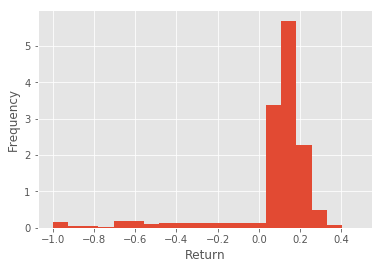

In [176]:
####Histogram of returns
plt.hist(df_filtered['irr'],density=1, bins=20) 
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

There are few things to note here
    1. Lending returns are clearly not normally distributed and very long tailed skewed to the left. 
    2. That means extreme losses are possible. Again, pooling loans to spread the default risk out is a key to a successful investment strategy.
    2. We have some unusually high return loans. These tend to be high interest rate loans that were prepaid very early. An example is shown below. I don't think there is a need to remove them since they are real loans, and our IRR calculation models their performance accurately.

##### High Return Outlier Example

In [164]:
df_filtered.loc[df_filtered.irr.argmax()][['loan_status_flag','total_pymnt','loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                               ,'collection_recovery_fee','recoveries','total_rec_late_fee','grade']]

loan_status_flag                             1
total_pymnt                            27994.4
loan_amnt                                24250
last_pymnt_amnt                        21261.9
installment                             962.77
issue_d                    2012-07-01 00:00:00
int_rate                                 24.89
last_pymnt_d               2013-03-01 00:00:00
total_pymnt                            27994.4
mo_diff                                      8
avg_pymnt                               3499.3
irr                                   0.477433
collection_recovery_fee                      0
recoveries                                   0
total_rec_late_fee                           0
grade                                        G
Name: 209351, dtype: object

##### Weighted Average IRR of all Completed Loans Originated from 2007-2012

In [197]:
###Weight the returns by funded amount to get more accurate representation
weighted_avg = np.average(df_filtered['irr'], weights=df_filtered['funded_amnt'])
weighted_avg

0.080955812334961436

it's important to note how the weighted average is higher than the raw averages. This is an indication that higher balance loans are better performing. We will investigate that

In [ ]:
Returns by weight buckets###########

##### Weighted Average of IRRs Bucketed by Year and Grade

In [ ]:
df_filtered.loc[df_filtered.irr.argmax()][['loan_status_flag','total_pymnt','loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                               ,'collection_recovery_fee','recoveries','total_rec_late_fee','grade']]

In [195]:
df_filtered.head(50)[['loan_status_flag','total_pymnt','loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                               ,'collection_recovery_fee','recoveries','total_rec_late_fee','grade']]

,loan_status_flag,total_pymnt,loan_amnt,last_pymnt_amnt,installment,issue_d,int_rate,last_pymnt_d,total_pymnt,mo_diff,avg_pymnt,irr,collection_recovery_fee,recoveries,total_rec_late_fee,grade
0,1.0,5861.071414,5000.0,171.62,162.87,2011-12-01,10.65,2015-01-01,5861.071414,37,158.407336,0.108497,0.0000,0.00,0.000000,B
2,1.0,3003.653644,2400.0,649.91,84.33,2011-12-01,15.96,2014-06-01,3003.653644,30,100.121788,0.197492,0.0000,0.00,0.000000,C
3,1.0,12226.302212,10000.0,357.48,339.31,2011-12-01,13.49,2015-01-01,12226.302212,37,330.440600,0.140254,0.0000,0.00,16.970000,C
5,1.0,5631.377753,5000.0,161.03,156.46,2011-12-01,7.90,2015-01-01,5631.377753,37,152.199399,0.079578,0.0000,0.00,0.000000,A
7,1.0,3938.144334,3000.0,111.34,109.43,2011-12-01,18.64,2015-01-01,3938.144334,37,106.436333,0.197126,0.0000,0.00,0.000000,E
11,1.0,13943.080000,12000.0,6315.30,402.54,2011-12-01,12.69,2013-09-01,13943.080000,21,663.956190,0.182487,0.0000,0.00,0.000000,B
12,0.0,2270.700000,9000.0,305.38,305.38,2011-12-01,13.49,2012-07-01,2270.700000,7,260.914286,-0.620779,4.1600,444.30,0.000000,C
13,1.0,3478.981915,3000.0,102.43,96.68,2011-12-01,9.91,2015-01-01,3478.981915,37,94.026538,0.100593,0.0000,0.00,0.000000,B
14,0.0,7471.990000,10000.0,325.74,325.74,2011-12-01,10.65,2013-10-01,7471.990000,22,310.313182,-0.214857,6.3145,645.10,0.000000,B
15,1.0,1270.171106,1000.0,36.32,35.31,2011-12-01,16.29,2015-01-01,1270.171106,37,34.328949,0.170241,0.0000,0.00,0.000000,D


In [196]:
df_group_irr = df_group.apply(lambda x: np.average(x['irr'],weights = x['funded_amnt']))
df_group_irr.argmax()

2012

G Grade in 2012 were the most profitable in terms of returns. Next in line were grade E loans in 2011.

In [179]:
df_group_irr

issue_yr
2007   -0.046138
2008   -0.017370
2009    0.059257
2010    0.072211
2011    0.068278
2012    0.073741
2013   -0.014730
2014   -0.385422
2015   -0.908301
dtype: float64

In [ ]:
###may want to pool by size of portfolio not n random 

In [ ]:
def cash_flow(row,max_n):
    initial_invest = -row['funded_amnt'] 
    avg_payment = row['avg_pymnt'] or 0 
    num_payments = int(row['mo_diff'])-1 
    fully_paid =row['loan_status_flag'] or 0 
    recovery = row['recoveries'] or 0 
    chargeoff_fee = -row['collection_recovery_fee'] or 0 
    dummy_cfs = int(max_n - row['mo_diff'])+2
    return [initial_invest]+[avg_payment]*num_payments + [recovery+chargeoff_fee]+ [0]*dummy_cfs

In [ ]:
##we calculate return using a pool of cash flows 
##avoids IRR's drastic treatment of negative IRR 
##automatically does weighted adjustment based on size of the loan
##we later can take many pools of data using functions built to effectively creat a derivative that is a pool of loans
##Pool of loans returns should be normally distributed, allowing us to do interesting analysis around normality
##and calculate things such as sharpe ratio
##More representative for institutional investors who will have a set of funds for an asset class and not
##investing in individual loans
##Diversification
def irr_pool(df):
    list_length = df['mo_diff'].max()
    cfs=[]
    for index, row in df.iterrows(): 
        cfs.append(cash_flow(row,list_length))
    result = [sum(x) for x in zip(*cfs)]
    return (np.irr(result)+1)**12 -1

In [26]:
def pool(df,pool_size):  
    pool_running = 0 
    df_pool = df.copy()
    df_out = pd.DataFrame()
    while (pool_running < pool_size):
        df_subset = df_pool.sample(1)
        ###no replacement
        df_pool = df_pool.drop(df_subset.index)
        pool_running += df_subset.iloc[0]['funded_amnt']
        df_out = df_out.append(df_subset)
    return df_out

In [27]:
def collect_n(df,n,pool_size):
    returns_list = []
    for x in range(0,n):
        df_out = pool(df,pool_size)
        returns_list.append(irr_pool(df_out))   
    return returns_list

In [28]:
def collect_n_random(df,n,size):
    returns_list = []
    for x in range(0,n):
        df_out = df.sample(size)
        returns_list.append(irr_pool(df_out))   
    return returns_list

In [29]:
def collect_n_random_stats(df,n,size):
    returns_list = []
    for x in range(0,n):
        df_out = df.sample(size)
        returns_list.append(irr_pool(df_out))   
    return [np.average(returns_list)] +[math.sqrt(np.var(returns_list))]

In [31]:
#out=collect_n(df_filtered,100,10000000)

In [32]:
out=collect_n_random(df_filtered,100,1000)

In [34]:
out=collect_n_random_stats(df_filtered,100,1000)

In [38]:
out

[0.07742042070855211, 0.007487511760440712]

In [192]:
df_conf_int = df_filtered.groupby(['issue_yr','grade'])['irr'].describe()
df_conf_int


count      mean       std       min       25%       50%  \
issue_yr grade                                                              
2007     A         78.0  0.082830  0.070134 -0.438335  0.076907  0.083683   
         B         98.0  0.020429  0.242970 -1.000000  0.091315  0.100726   
         C        141.0 -0.009480  0.286711 -0.999994  0.100275  0.114586   
         D         99.0 -0.030242  0.312548 -0.895951 -0.108746  0.132229   
         E        100.0 -0.038894  0.354898 -0.997666 -0.208450  0.146472   
         F         52.0 -0.178519  0.440138 -0.999895 -0.584562  0.157401   
         G         35.0 -0.117846  0.433092 -0.997369 -0.599380  0.182117   
2008     A        318.0  0.070205  0.132637 -0.995265  0.082890  0.089788   
         B        594.0  0.012507  0.272294 -1.000000  0.098704  0.109456   
         C        580.0  0.001094  0.309619 -1.000000  0.113035  0.125673   
         D        419.0 -0.025125  0.347494 -1.000000  0.018547  0.140722   
         E        285.0  0.017571  0.314707 -1.000000  0.052347  0.157861   
         F        111.0 -0.070487  0.426614 -1.000000 -0.365748  0.169479   
         G         86.0 -0.010902  0.397196 -1.000000 -0.160056  0.195031   
2009     A       1203.0  0.065057  0.164285 -0.998282  0.083378  0.096850   
         B       1445.0  0.061433  0.247606 -1.000000  0.118587  0.128729   
         C       1348.0  0.063146  0.269533 -1.000000  0.134606  0.144311   
         D        817.0  0.068037  0.279149 -1.000000  0.150174  0.161030   
         E        308.0  0.050240  0.333314 -1.000000  0.163960  0.179240   
         F        105.0  0.053870  0.338115 -1.000000  0.128384  0.201816   
         G         55.0  0.066033  0.321061 -1.000000 -0.038228  0.214282   
2010     A       2567.0  0.062914  0.121417 -0.999999  0.070465  0.079417   
         B       2805.0  0.075246  0.193198 -1.000000  0.105830  0.118000   
         C       2070.0  0.081937  0.239727 -1.000000  0.135141  0.147892   
         D       1253.0  0.068183  0.290246 -1.000000  0.153916  0.164556   
         E        336.0  0.072511  0.309722 -1.000000  0.168107  0.185778   
         F         91.0  0.034783  0.375454 -1.000000  0.017953  0.202489   
         G         34.0  0.022608  0.385320 -0.996942 -0.238323  0.222606   
2011     A       5579.0  0.049728  0.150487 -0.999999  0.067258  0.078953   
         B       4722.0  0.076483  0.196876 -1.000000  0.107973  0.123151   
         C       2203.0  0.077172  0.250313 -1.000000  0.137625  0.152154   
         D       1261.0  0.091802  0.268846 -1.000000  0.159234  0.176962   
         E        272.0  0.095604  0.297560 -0.999687  0.172086  0.203964   
         F         54.0  0.100095  0.316695 -0.997243  0.190805  0.221353   
         G         10.0 -0.005955  0.401757 -0.671349 -0.226387  0.217606   
2012     A      10741.0  0.054924  0.157860 -1.000000  0.075606  0.086466   
         B      16757.0  0.083737  0.209992 -1.000000  0.117263  0.139156   
         C       9866.0  0.095063  0.256093 -1.000000  0.152384  0.170646   
         D       5063.0  0.109055  0.292556 -1.000000  0.186457  0.204355   
         E        790.0  0.136045  0.303464 -1.000000  0.211679  0.236398   
         F        103.0  0.157586  0.323168 -0.999579  0.238444  0.259315   
         G         24.0  0.209663  0.363744 -0.837159  0.270485  0.304216   

                     75%       max  
issue_yr grade                      
2007     A      0.111586  0.137220  
         B      0.112774  0.171528  
         C      0.121812  0.193131  
         D      0.145030  0.225062  
         E      0.154738  0.260624  
         F      0.172413  0.284126  
         G      0.203861  0.293872  
2008     A      0.107235  0.153155  
         B      0.128918  0.200795  
         C      0.139245  0.229776  
         D      0.152903  0.258545  
         E      0.177610  0.307221  
         F      0.189608  0.290011  
         G      0.206344  0.337564  
2009     A      0.113418  0.169200  


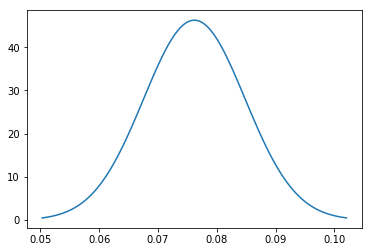

In [33]:
mu = np.average(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

In [ ]:
cust = lambda g: collect_n_random_stats

In [85]:
df_group = df_filtered.groupby(['issue_yr'])
df_group.count()
df_sharpe =df_group.apply(lambda x: collect_n_random_stats(x,100,100))
#df_group_irr = df_group.apply(lambda x:collect_n_random_stats(x,10,np.min(1000, x.count().loc[0]/10)))

AttributeError: 'Series' object has no attribute 'columns'

In [102]:
mean = [sublist[0] for sublist in df_sharpe.values]
stdev = [sublist[1] for sublist in df_sharpe.values]

In [101]:
df_sharpe.values

array([list([-0.021994030681171541, 0.035105320861345504]),
       list([0.012029604236237019, 0.03750651742601825]),
       list([0.065858730807501459, 0.026245380469597266]),
       list([0.077805637952297529, 0.022353631333799848]),
       list([0.075162485450149502, 0.021103132367924656]),
       list([0.083078250625224129, 0.025157282018253565])], dtype=object)

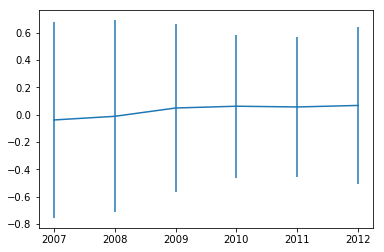

In [107]:
####Confidence Intervals on IRR of overall market
df_conf_int = df_filtered.groupby(['issue_yr'])['irr'].describe()
# example data
x = df_conf_int.index
y = df_conf_int['mean']
yerr = df_conf_int['std']*2
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr)
plt.show()




In [68]:
df_group = df_filtered.groupby(['issue_yr'])
df_sharpe =df_group.apply(lambda x: collect_n_random_stats(x,100,100))
#df_group_irr = df_group.apply(lambda x:collect_n_random_stats(x,10,np.min(1000, x.count().loc[0]/10)))

In [84]:
mean = [sublist[0] for sublist in df_sharpe.values]
stdev = [sublist[1] for sublist in df_sharpe.values]

[0.0069959368306351296, 0.03490798222429893]

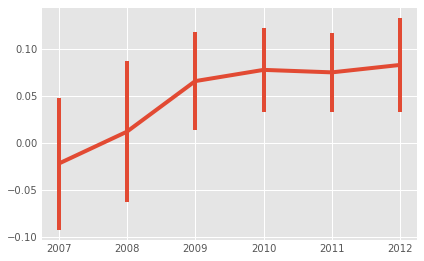

In [124]:
x = df_sharpe.index
y = [sublist[0] for sublist in df_sharpe.values]
yerr = [sublist[1]*2 for sublist in df_sharpe.values]
fig, ax = plt.subplots()
ax.errorbar(x, y,  yerr=yerr)






In [148]:
df_filtered_year = df_filtered[(df_filtered['issue_yr'] >=2009) & (~df_filtered['grade'].isin(['F','G']))].copy()
df_group_grade = df_filtered_year.groupby(['issue_yr','grade'])
df_sharpe_grade =df_group_grade.apply(lambda x: collect_n_random_stats(x,100,100))


In [149]:
df_sharpe_grade

issue_yr  grade
2009      A        [0.0688505576663, 0.015858195765848362]
          B        [0.0573407476198, 0.028003886412191543]
          C        [0.0657707165657, 0.028113362135889605]
          D        [0.0758069795791, 0.025504547667911808]
          E        [0.0522236834097, 0.029799445884017478]
2010      A        [0.0622168833716, 0.011475527085663262]
          B        [0.0768044736296, 0.020938987098078548]
          C        [0.0899831129427, 0.023518947934158346]
          D         [0.089723306613, 0.027768986640094567]
          E        [0.0922577087941, 0.025426155245442464]
2011      A         [0.0501762758909, 0.01705806443081306]
          B         [0.0821554139735, 0.01946972545873796]
          C         [0.0803901872347, 0.02584361105208549]
          D         [0.114915744066, 0.023029188479757153]
          E          [0.13938548677, 0.016054701323236338]
2012      A        [0.0480873066226, 0.021059367227982663]
          B         [0.0824232125945, 0.

In [140]:
x=df_filtered.loc[df_filtered['irr'].argmax()]
initial_invest = -x['funded_amnt']
avg_payment = x['avg_pymnt']
num_payments = int(x['mo_diff'])-1    
fully_paid = x['loan_status_flag']
recovery = x['recoveries']
chargeoff_fee = -x['collection_recovery_fee']
x['total_pymnt']
x['recoveries']

1516.3800000000001

In [ ]:
##Portfolio Optimization


In [ ]:
def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b, c = params # <-- for readability you may wish to assign names to the component variables
    return a**2 + b**2 + c**2

initial_guess = [1, 1, 1]
result = optimize.minimize(f, initial_guess, bounds = [(.25, 1), (-1, 20),(0,1)])
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

In [ ]:
df_filtered.loc[df_filtered.irr.argmax()][['loan_status_flag','total_pymnt','loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                               ,'collection_recovery_fee','recoveries','total_rec_late_fee','grade']]

Absurd G rate loan. That was prepaid super early but also collected 25% interest rate

## Assumptions & Discussions
1. Funded Amount vs Funded Amount Inv: Where there are differences, lending tree stepped in to make up for the differences between loan amount and funed amount invested by investors. We will go ahead and use funded amount as a basis for all our analysis.
2. We assume all cash is deployed on year of x(has the most data) to reduce cash drag. We calculate IRR-> assuming we can reinvest at this rate 
3. Returns on the loans are most likely not normally distributed but a pool of randomly sampled loans should be

In [ ]:
###appendix

##limitation of individual IRR
### 3 years is too much of a delay, cosnider a strategy where you hold for 12 months & sell.
### This allows better modeling

def nar_calc(x):
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = int(x['mo_diff'])   
    fully_paid = x['loan_status_flag']
    charge_off = x['funded_amnt_inv'] - x['total_rec_prncp'] - x['recoveries'] + x['collection_recovery_fee']
    chargeoff_fee = -x['collection_recovery_fee']
    
    balance = x['funded_amnt']
    annual_interest_rate = x['int_rate']/100
    monthly_interest_rate = annual_interest_rate / 12
    monthly_payment = x['installment']
    
    for month in range(1, num_payments):
        if(month != num_payments-1):
            balance = (balance - monthly_payment) * (1 + monthly_interest_rate)
        else: 
            balance = 0
        print('Month: %d \n Minimum monthly payment: %g \n Remaining balance: %g'\
              % (month, round(monthly_payment, 2), round(balance,2)))


In [43]:
df_group_irr

grade  issue_yr
A      2007        0.097217
       2008        0.050469
       2009        0.063518
       2010        0.061746
       2011        0.049488
       2012        0.047840
B      2007       -0.039109
       2008       -0.008372
       2009        0.045722
       2010        0.071959
       2011        0.079730
       2012        0.075244
C      2007       -0.023057
       2008       -0.037433
       2009        0.046296
       2010        0.079125
       2011        0.073962
       2012        0.083807
D      2007       -0.071354
       2008       -0.088469
       2009        0.051466
       2010        0.076116
       2011        0.103879
       2012        0.101165
E      2007       -0.093475
       2008       -0.016077
       2009        0.025696
       2010        0.075759
       2011        0.131390
       2012        0.119628
F      2007       -0.223625
       2008       -0.141651
       2009       -0.011275
       2010       -0.028241
       2011        0.087206
    